In [25]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import clip
from scripts.plot import show_cam_on_image,generate_shades_with_alpha,plot_text_with_colors
from salicncy import chefer,fast_ig,gradcam,m2ib,mfaba,nib,rise,saliencymap
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def visualize_vandt_heatmap(axs_t,axs_v, tmap, vmap, text_words, image, max_width=100, max_height=4):
    text_words = [x.split('<')[0] for x in text_words[1:-1]] # remove start and end tokens
    # fig, axs = plt.subplots(1, 2)
    # fig.set_size_inches(6,3) 
    #axs[0].imshow(np.float32(image)*np.expand_dims(vmap, axis=2))
    axs_v.imshow(show_cam_on_image(np.float32(image), vmap, use_rgb=True))
    # show bounding box if available
    axs_v.axis('off')
    rgba_colors = generate_shades_with_alpha(tmap[1:-1])
    plot_text_with_colors(axs_t, text_words, rgba_colors, max_width=max_width, max_height=max_height, fontsize=14)
    axs_t.set_xlim(0, max_width)
    axs_t.set_ylim(-max_height, max_height)
    axs_t.axis('off')
    #plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

In [27]:
def plot(axs_t,axs_v,tokenizer,processor, image_path, text, vmap, tmap):
    # Preprocess image
    image = Image.open(image_path).convert('RGB')
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    visualize_vandt_heatmap(axs_t,axs_v,tmap, vmap, text_words, image_under)

In [28]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

# Visualize

In [29]:
def generate_plot(axs_t,axs_v,img_path,text,method):
    image = Image.open(img_path).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device)
    image_features = model.get_image_features(image_feat)
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    text_features = model.get_text_features(text_ids)

    if method in [chefer,fast_ig,gradcam,mfaba,saliencymap]:
        vmap, tmap = method(model, processor, [text], [image])
    elif method == rise:
        vmap, tmap = rise(model, image_feat,[text_ids],image_features,text_features)
        tmap = [tmap[0].detach().cpu().numpy()]
    elif method == m2ib:
        vmap, tmap = m2ib(model, [text_ids], image_feat, 0.1)
    elif method == nib:
        vmap, tmap = nib(model, [text_ids], image_feat,10, 9)
    if vmap.shape[1] == 3:
        vmap = vmap.mean(1)
    plot(axs_t,axs_v,tokenizer, processor, img_path, text, vmap.squeeze(), tmap[0])

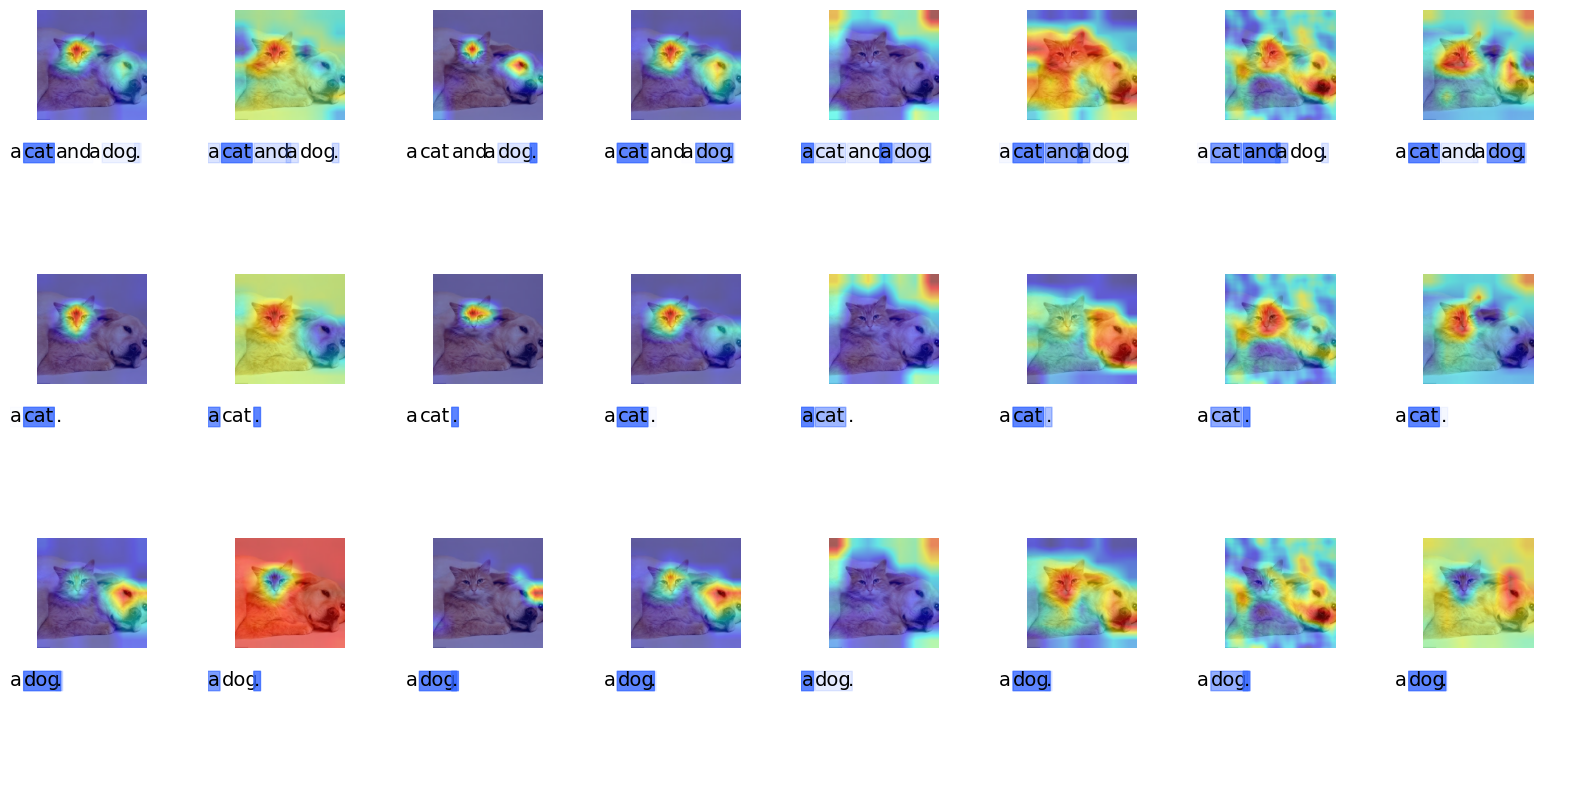

In [30]:
fig, axs = plt.subplots(6,8)
fig.set_size_inches(20, 10)
img_path = "images/cat-dog.jpg"
text = "a cat and a dog."
generate_plot(axs[1,0],axs[0,0],img_path,text,chefer)
generate_plot(axs[1,1],axs[0,1],img_path,text,fast_ig)
generate_plot(axs[1,2],axs[0,2],img_path,text,gradcam)
generate_plot(axs[1,3],axs[0,3],img_path,text,m2ib)
generate_plot(axs[1,4],axs[0,4],img_path,text,mfaba)
generate_plot(axs[1,5],axs[0,5],img_path,text,saliencymap)
generate_plot(axs[1,6],axs[0,6],img_path,text,rise)
generate_plot(axs[1,7],axs[0,7],img_path,text,nib)

text = "a cat."
generate_plot(axs[3,0],axs[2,0],img_path,text,chefer)
generate_plot(axs[3,1],axs[2,1],img_path,text,fast_ig)
generate_plot(axs[3,2],axs[2,2],img_path,text,gradcam)
generate_plot(axs[3,3],axs[2,3],img_path,text,m2ib)
generate_plot(axs[3,4],axs[2,4],img_path,text,mfaba)
generate_plot(axs[3,5],axs[2,5],img_path,text,saliencymap)
generate_plot(axs[3,6],axs[2,6],img_path,text,rise)
generate_plot(axs[3,7],axs[2,7],img_path,text,nib)

text = "a dog."
generate_plot(axs[5,0],axs[4,0],img_path,text,chefer)
generate_plot(axs[5,1],axs[4,1],img_path,text,fast_ig)
generate_plot(axs[5,2],axs[4,2],img_path,text,gradcam)
generate_plot(axs[5,3],axs[4,3],img_path,text,m2ib)
generate_plot(axs[5,4],axs[4,4],img_path,text,mfaba)
generate_plot(axs[5,5],axs[4,5],img_path,text,saliencymap)
generate_plot(axs[5,6],axs[4,6],img_path,text,rise)
generate_plot(axs[5,7],axs[4,7],img_path,text,nib)

